In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
btc = pd.read_csv("BTC-USD.csv")  # Read in file

In [3]:
btc

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-01-11,908.114990,919.447998,762.765015,777.757019,777.757019,310928992
1,2017-01-12,775.177979,826.245972,755.755981,804.833984,804.833984,222326000
2,2017-01-13,803.737000,829.000977,780.002991,823.984009,823.984009,168968000
3,2017-01-14,825.142029,835.085022,812.455994,818.411987,818.411987,93063296
4,2017-01-15,818.142029,823.307007,812.870972,821.797974,821.797974,71013600
...,...,...,...,...,...,...,...
1822,2022-01-07,43153.570313,43153.570313,41077.445313,41557.902344,41557.902344,84196607520
1823,2022-01-08,41561.464844,42228.941406,40672.277344,41733.941406,41733.941406,28066355845
1824,2022-01-09,41734.726563,42663.949219,41338.160156,41911.601563,41911.601563,21294384372
1825,2022-01-10,41910.230469,42199.484375,39796.570313,41821.261719,41821.261719,32104232331


# Prep and Transform Data

In [4]:
# Prepare dataframe for transformations

btc = btc[['Date', 'Adj Close', 'Volume']]  # Select only needed columns

btc = btc.sort_values(by=['Date'], ascending = False).reset_index(drop=True)  # Sort data by date descending

In [5]:
# Feature Engineering

btc['Close_-1'] = btc['Adj Close'].shift(-1)  # Create a new column showing previous Adj Close

btc['Delta'] = (btc['Adj Close'] - btc['Close_-1']) / btc['Close_-1']  # Create a column showing day-over-day change as %

# Create a target variable column
new_col = {'Delta_Class_Numeric':[]}
new_col = pd.DataFrame(new_col)
for x in np.arange(0,len(btc)):
    if btc.loc[x]['Delta'] >= 0.02:
        new_col.loc[x] = 1
    elif btc.loc[x]['Delta'] <= -0.02:
        new_col.loc[x] = -1
    else:
        new_col.loc[x] = 0
        
btc['Delta_Class_Numeric'] = new_col

btc['Close_-1_Delta'] = btc['Delta'].shift(-1)  # Create a new column showing previous Delta

# Create another target variable column showing a weighted average of future returns compared to today's price
btc['AVG_Weighted_Future_Return'] = ((btc['Adj Close'].shift(1) - btc['Adj Close']) / btc['Adj Close'] * 0.6) + ((btc['Adj Close'].shift(3) - btc['Adj Close']) / btc['Adj Close'] * 0.3) + ((btc['Adj Close'].shift(5) - btc['Adj Close']) / btc['Adj Close'] * 0.1)

In [6]:
# Create a new column that indicates if there was a run of 3 consecutive days of gains

new_col = {'Gain_Run':[]}
new_col = pd.DataFrame(new_col)
for x in np.arange(0,len(btc)-3):
    a = btc.loc[x]['Close_-1_Delta']
    b = btc.loc[x + 1]['Close_-1_Delta']
    c = btc.loc[x + 2]['Close_-1_Delta']
    if (a > 0) & (b > 0) & (c > 0):
        new_col.loc[x] = 1
    else:
        new_col.loc[x] = 0
        
btc['Gain_Run'] = new_col

In [7]:
# Create a new column that indicates if there was a run of 3 consecutive days of losses

new_col = {'Gain_Loss':[]}
new_col = pd.DataFrame(new_col)
for x in np.arange(0,len(btc)-3):
    a = btc.loc[x]['Close_-1_Delta']
    b = btc.loc[x + 1]['Close_-1_Delta']
    c = btc.loc[x + 2]['Close_-1_Delta']
    if (a < 0) & (b < 0) & (c < 0):
        new_col.loc[x] = 1
    else:
        new_col.loc[x] = 0
        
btc['Gain_Loss'] = new_col

In [8]:
# Sort data back to ascending by date

btc = btc.sort_values(by=['Date'], ascending = True).reset_index(drop=True)

In [9]:
# Feature engineering part 2 - create columns that are date ascending dependent

btc['7-Day_Delta_AVG'] = btc['Close_-1_Delta'].rolling(7).mean()

btc['30-Day_Delta_AVG'] = btc['Close_-1_Delta'].rolling(30).mean()

btc['7-Day_High'] = btc['Close_-1'].rolling(7).max()

btc['30-Day_High'] = btc['Close_-1'].rolling(30).max()

btc['365-Day_High'] = btc['Close_-1'].rolling(365).max()

btc['7-Day_Low'] = btc['Close_-1'].rolling(7).min()

btc['30-Day_Low'] = btc['Close_-1'].rolling(30).min()

btc['365-Day_Low'] = btc['Close_-1'].rolling(365).min()

btc['Diff_from_7-Day_High'] = (btc['Close_-1'] - btc['7-Day_High']) / btc['7-Day_High']

btc['Diff_from_7-Day_Low'] = (btc['Close_-1'] - btc['7-Day_Low']) / btc['7-Day_Low']

btc['7-Day_AVG_Price'] = btc['Close_-1'].rolling(7).mean()

btc['30-Day_AVG_Price'] = btc['Close_-1'].rolling(30).mean()

btc['50-Day_AVG_Price'] = btc['Close_-1'].rolling(50).mean()

btc['100-Day_AVG_Price'] = btc['Close_-1'].rolling(100).mean()

btc['7-Day_AG_to_30-Day_AVG'] = (btc['7-Day_AVG_Price'] - btc['30-Day_AVG_Price']) / btc['30-Day_AVG_Price']

btc['30-Day_AG_to_50-Day_AVG'] = (btc['30-Day_AVG_Price'] - btc['50-Day_AVG_Price']) / btc['50-Day_AVG_Price']

btc['50-Day_AG_to_100-Day_AVG'] = (btc['50-Day_AVG_Price'] - btc['100-Day_AVG_Price']) / btc['100-Day_AVG_Price']

btc['7_to_30_5-Day_AVG'] = btc['7-Day_AG_to_30-Day_AVG'].rolling(5).mean()

btc['30_to_50_5-Day_AVG'] = btc['30-Day_AG_to_50-Day_AVG'].rolling(5).mean()

btc['50_to_100_5-Day_AVG'] = btc['50-Day_AG_to_100-Day_AVG'].rolling(5).mean()

In [10]:
# Sort data again to show most recent dates first

btc = btc.sort_values(by=['Date'], ascending = False).reset_index(drop=True)  

In [11]:
# Add year and month classifiers as columns for filtering and checking seasonality

btc['Year'] = pd.to_datetime(btc['Date']).dt.year

btc['Month'] = pd.to_datetime(btc['Date']).dt.month

In [12]:
btc

,Date,Adj Close,Volume,Close_-1,Delta,Delta_Class_Numeric,Close_-1_Delta,AVG_Weighted_Future_Return,Gain_Run,Gain_Loss,...,50-Day_AVG_Price,100-Day_AVG_Price,7-Day_AG_to_30-Day_AVG,30-Day_AG_to_50-Day_AVG,50-Day_AG_to_100-Day_AVG,7_to_30_5-Day_AVG,30_to_50_5-Day_AVG,50_to_100_5-Day_AVG,Year,Month
0,2022-01-11,41474.167969,31108497408,41821.261719,-0.008299,0.0,-0.002155,NaN,0.0,0.0,...,49523.212188,54863.891680,-0.086846,-0.053399,-0.097344,-0.064477,-0.057238,-0.086561,2022,1
1,2022-01-10,41821.261719,32104232331,41911.601563,-0.002155,0.0,0.004257,NaN,0.0,0.0,...,49861.396485,54922.793945,-0.077662,-0.054778,-0.092155,-0.054211,-0.058829,-0.080869,2022,1
2,2022-01-09,41911.601563,21294384372,41733.941406,0.004257,0.0,0.004236,NaN,0.0,0.0,...,50217.108360,54984.847344,-0.064719,-0.057935,-0.086710,-0.045013,-0.060447,-0.074962,2022,1
3,2022-01-08,41733.941406,28066355845,41557.902344,0.004236,0.0,-0.037141,NaN,0.0,1.0,...,50544.821094,55005.416875,-0.050714,-0.060127,-0.081094,-0.037869,-0.062264,-0.068767,2022,1
4,2022-01-07,41557.902344,84196607520,43160.929688,-0.037141,-1.0,-0.009366,NaN,0.0,1.0,...,50852.505781,55005.481485,-0.042446,-0.059949,-0.075501,-0.031427,-0.064649,-0.062182,2022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1822,2017-01-15,821.797974,71013600,818.411987,0.004137,0.0,-0.006762,0.039682,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,1
1823,2017-01-14,818.411987,93063296,823.984009,-0.006762,0.0,0.023794,0.045155,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,1
1824,2017-01-13,823.984009,168968000,804.833984,0.023794,1.0,0.034814,0.006293,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,1
1825,2017-01-12,804.833984,222326000,777.757019,0.034814,1.0,NaN,0.033410,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017,1


In [13]:
# Remove rows with NaN

btc = btc.dropna()

# Visualize and Explore Data

In [14]:
btc

,Date,Adj Close,Volume,Close_-1,Delta,Delta_Class_Numeric,Close_-1_Delta,AVG_Weighted_Future_Return,Gain_Run,Gain_Loss,...,50-Day_AVG_Price,100-Day_AVG_Price,7-Day_AG_to_30-Day_AVG,30-Day_AG_to_50-Day_AVG,50-Day_AG_to_100-Day_AVG,7_to_30_5-Day_AVG,30_to_50_5-Day_AVG,50_to_100_5-Day_AVG,Year,Month
5,2022-01-06,43160.929688,30208048289,43569.003906,-0.009366,0.0,-0.050734,-0.034876,0.0,1.0,...,51196.647422,54984.217617,-0.035512,-0.061359,-0.068885,-0.025447,-0.067486,-0.055310,2022,1
6,2022-01-05,43569.003906,36851084859,45897.574219,-0.050734,-1.0,-0.012066,-0.022267,0.0,1.0,...,51528.492266,54970.884883,-0.031674,-0.062867,-0.062622,-0.020436,-0.070086,-0.048463,2022,1
7,2022-01-04,45897.574219,42494677905,46458.117188,-0.012066,0.0,-0.018737,-0.067490,0.0,0.0,...,51881.698203,54943.994531,-0.028997,-0.067017,-0.055735,-0.015038,-0.072313,-0.041411,2022,1
8,2022-01-03,46458.117188,33071628362,47345.218750,-0.018737,0.0,-0.007163,-0.038699,0.0,0.0,...,52261.872656,54906.579297,-0.018507,-0.072054,-0.048167,-0.009414,-0.073719,-0.034205,2022,1
9,2022-01-02,47345.218750,27951569547,47686.812500,-0.007163,0.0,0.029809,-0.047394,0.0,0.0,...,52604.358828,54861.524610,-0.012546,-0.074133,-0.041143,-0.006154,-0.074123,-0.026881,2022,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,2018-01-15,13819.799805,12750799872,13772.000000,0.003471,0.0,-0.040960,-0.158693,0.0,0.0,...,14691.666172,10597.504883,-0.073739,0.052480,0.386333,-0.032673,0.083182,0.390778,2018,1
1458,2018-01-14,13772.000000,11084099584,14360.200195,-0.040960,-1.0,0.027152,-0.069910,0.0,0.0,...,14592.044570,10503.492983,-0.056744,0.068654,0.389256,-0.017265,0.098730,0.392665,2018,1
1459,2018-01-13,14360.200195,12763599872,13980.599609,0.027152,1.0,0.042877,-0.104620,0.0,0.0,...,14469.914375,10403.175083,-0.032291,0.082751,0.390913,-0.004924,0.113520,0.394253,2018,1
1460,2018-01-12,13980.599609,12065699840,13405.799805,0.042877,1.0,-0.104686,-0.007130,0.0,0.0,...,14351.077783,10305.662686,-0.005977,0.097355,0.392543,-0.000184,0.127850,0.395686,2018,1


### Distribution Plots

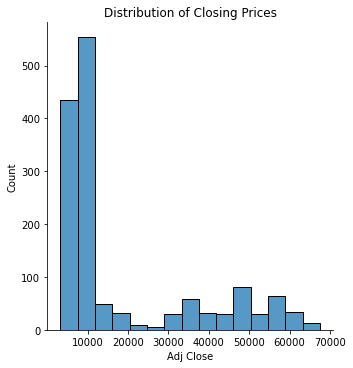

In [15]:
sns.displot(btc['Adj Close']).set(title='Distribution of Closing Prices')  # Distribution of Adjusted Close Prices

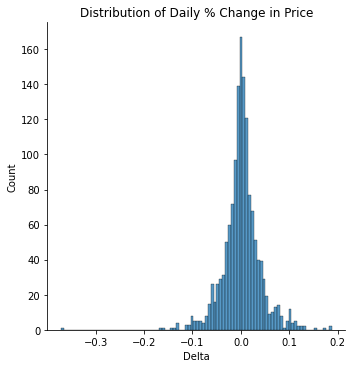

In [16]:
sns.displot(btc['Delta']).set(title='Distribution of Daily % Change in Price')  # Distribution of day-to-day changes in price

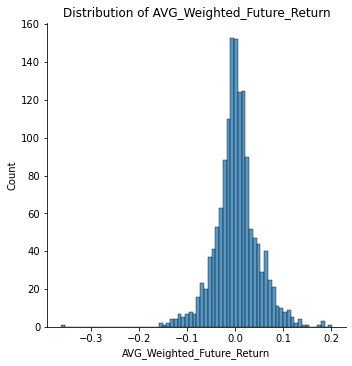

In [17]:
sns.displot(btc['AVG_Weighted_Future_Return']).set(title='Distribution of AVG_Weighted_Future_Return') # Distribution of 'AVG_Weighted_Future_Return'

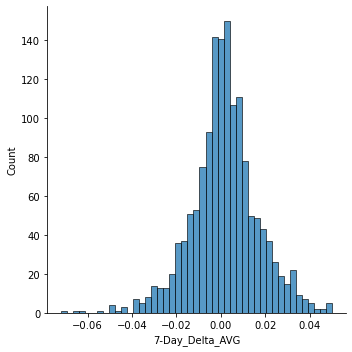

In [18]:
sns.displot(btc['7-Day_Delta_AVG']) # Distribution of '7-Day_Delta_AVG'

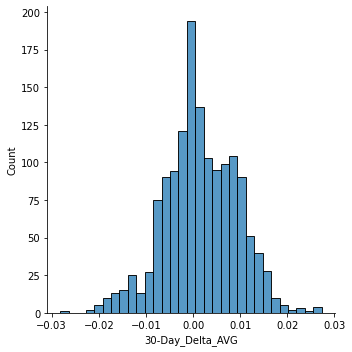

In [19]:
sns.displot(btc['30-Day_Delta_AVG']) # Distribution of '30-Day_Delta_AVG'

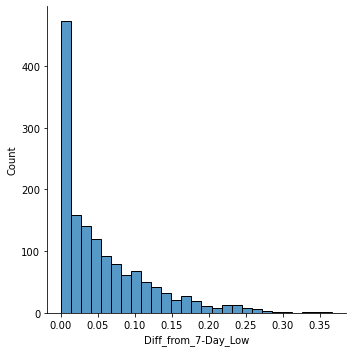

In [20]:
sns.displot(btc['Diff_from_7-Day_Low']) # Distribution of 'Diff_from_7-Day_Low' 

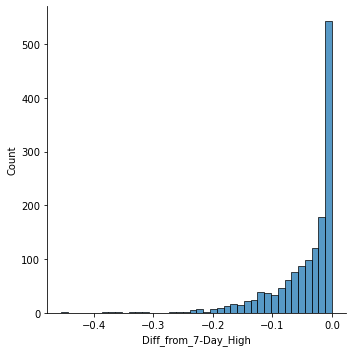

In [21]:
sns.displot(btc['Diff_from_7-Day_High']) # Distribution of 'Diff_from_7-Day_High' 

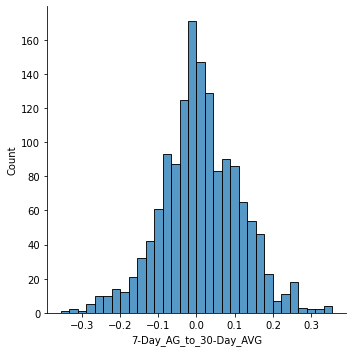

In [22]:
sns.displot(btc['7-Day_AG_to_30-Day_AVG']) # Distribution of '7-Day_AG_to_30-Day_AVG' 

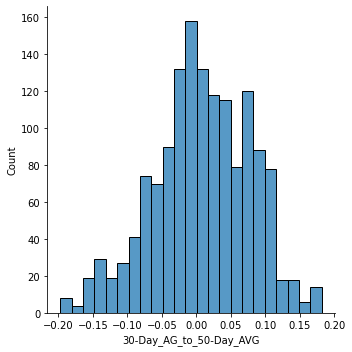

In [23]:
sns.displot(btc['30-Day_AG_to_50-Day_AVG']) # Distribution of '30-Day_AG_to_50-Day_AVG'

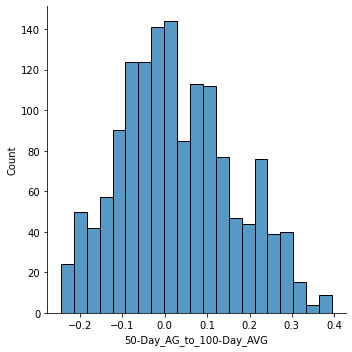

In [24]:
sns.displot(btc['50-Day_AG_to_100-Day_AVG']) # Distribution of '50-Day_AG_to_100-Day_AVG'

### Correlation Matrix 

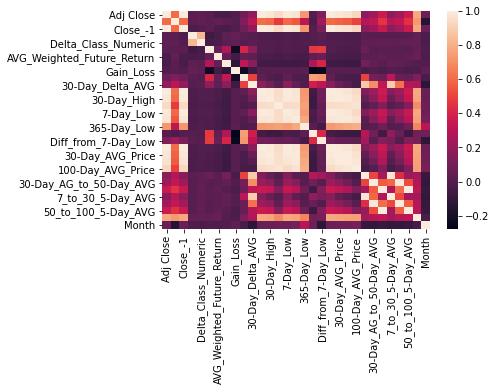

In [25]:
corr_matrix = btc.corr()

sns.heatmap(corr_matrix)

### Scatterplots

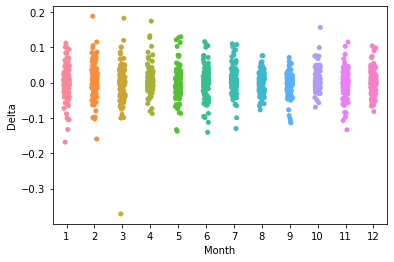

In [26]:
sns.stripplot(x='Month',
              y='Delta',
              data=btc)

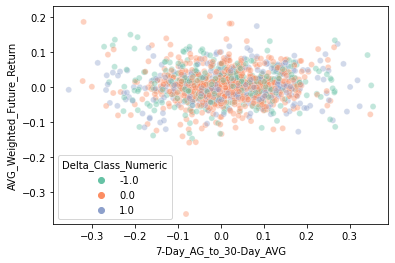

In [27]:
sns.scatterplot(x='7-Day_AG_to_30-Day_AVG',
                y='AVG_Weighted_Future_Return',
                data=btc,
                hue='Delta_Class_Numeric',
                palette="Set2",
                alpha=0.4)

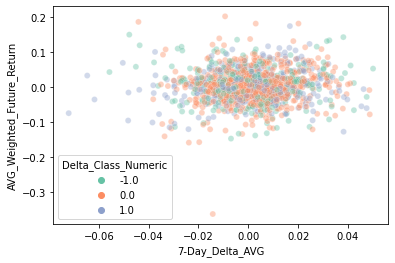

In [28]:
sns.scatterplot(x='7-Day_Delta_AVG',
                y='AVG_Weighted_Future_Return',
                data=btc,
                hue='Delta_Class_Numeric',
                palette="Set2",
                alpha=0.4)

# Build and Test Predictive Models

In [29]:
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.neighbors import (
    KNeighborsRegressor,
    KNeighborsClassifier)
from sklearn.linear_model import (
    LinearRegression,
    Lasso,
    LogisticRegression
)
from sklearn.ensemble import (
    BaggingClassifier,
    BaggingRegressor,
    RandomForestRegressor,
    RandomForestClassifier
)
from sklearn.metrics import (
    accuracy_score,
    mean_squared_error,
    plot_confusion_matrix,
    precision_score,
    recall_score
)
from sklearn.model_selection import (
    GridSearchCV,
    KFold,
    train_test_split
)
from sklearn.tree import (
    DecisionTreeClassifier,
    DecisionTreeRegressor,
    plot_tree
)

### Select subset of data and do train_test_split

In [30]:
btc_2022 = btc[btc['Year'] == 2021 | 2022]  # Separate 2022 data

btc = btc[btc['Year'] != 2021 | 2022]  # Remove 2022 data from the model

### Predict against 'AVG_Weighted_Future_Return' 

In [31]:
# Get Y and X variables

Y = btc['AVG_Weighted_Future_Return']

X = btc.iloc[:, np.r_[3:4,6,8:32]]

# Split out Test Data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

# Collect 2022 data that the model will be applied to

Z = btc_2022.iloc[:, np.r_[3:4,6,8:32]]

### Linear Regression

In [33]:
# Linear Regression

simple_linear_regression = LinearRegression().fit(X_train, Y_train)

In [34]:
mean_squared_error(Y_train, simple_linear_regression.predict(X_train))

0.0018611654483913069

In [35]:
mean_squared_error(Y_test, simple_linear_regression.predict(X_test))

0.00216127742746468

### LASSO Regression 

In [36]:
# Lasso

lasso_pipeline = make_pipeline(Lasso())

alpha_candidates = np.logspace(-2.0, 1.0)

alpha_search = GridSearchCV(lasso_pipeline,
             {'lasso__alpha': alpha_candidates},
             cv=10).fit(X_train,Y_train)

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8648794004970544, tolerance: 0.00017975261390521232
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.878895172882357, tolerance: 0.00018241423825076657
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8189604348763456, tolerance: 0.0001719667929473248
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8664091343275779, tolerance: 0.00018030815526137505
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8522772551238874, tolerance: 0.00017975261390521232
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8686226272490278, tolerance: 0.00018241423825076657
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529:

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8326667475068162, tolerance: 0.00017975261390521232
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.852765467486431, tolerance: 0.00018241423825076657
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7789259382183987, tolerance: 0.0001719667929473248
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: C

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8018320179829082, tolerance: 0.00017867233355754362
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.8250195853552781, tolerance: 0.00018030815526137505
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.789165040147096, tolerance: 0.00017975261390521232
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: 

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5902386007117906, tolerance: 0.0001831245905537193
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7477835206435139, tolerance: 0.00018188671411527906
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7633073245734454, tolerance: 0.00018589080413338366
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: 

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5613924900362459, tolerance: 0.0001814563755606575
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.6811464202164564, tolerance: 0.00017867233355754362
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.7215924173366972, tolerance: 0.00018030815526137505
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: 

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5568385112905225, tolerance: 0.00018188671411527906
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5676140052071523, tolerance: 0.00018589080413338366
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.5999861221921796, tolerance: 0.00017973803186012528
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529:

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4002749208218812, tolerance: 0.00018589080413338366
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45159100197472235, tolerance: 0.00017973803186012528
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.22278666324568708, tolerance: 0.0001814563755606575
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.10514087569363406, tolerance: 0.0001719667929473248
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0669158289126115, tolerance: 0.0001831245905537193
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.1339344685756625, tolerance: 0.00018188671411527906
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: 

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.010285213681091143, tolerance: 0.00018030815526137505
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0039042461476768153, tolerance: 0.00017975261390521232
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0034949882113390895, tolerance: 0.00018241423825076657
  model = cd_fast.enet_coordinate_descent(
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent

In [37]:
best_alpha = alpha_search.best_params_.get("lasso__alpha")
best_alpha

10.0

In [38]:
lasso_fit = Lasso(alpha = best_alpha).fit(X_train, Y_train)

In [39]:
mean_squared_error(Y_train, lasso_fit.predict(X_train))

0.0019635301888130514

In [40]:
mean_squared_error(Y_test, lasso_fit.predict(X_test))

0.0022681858526457897

### Decision Tree 

In [41]:
# Decision Tree

grid_search_cv_dt = GridSearchCV(DecisionTreeRegressor(random_state=42),
                              param_grid=dict(min_impurity_decrease=np.arange(-2.00, 2.00, 0.01)),
                              cv=KFold(n_splits=2, shuffle=True, random_state=42)).fit(X_train, Y_train)

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 1242, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partitio

In [42]:
grid_search_cv_dt.best_params_

{'min_impurity_decrease': 0.010000000000001563}

In [43]:
mean_squared_error(Y_train, grid_search_cv_dt.best_estimator_.predict(X_train))

0.0019685221571381713

In [44]:
mean_squared_error(Y_test, grid_search_cv_dt.best_estimator_.predict(X_test))

0.002264269908118554

### Bagged Tree 

In [45]:
# Bagging

bag_fit = BaggingRegressor(base_estimator=DecisionTreeRegressor(random_state=42, max_depth=5),random_state=42).fit(X_train, Y_train)

In [46]:
mean_squared_error(Y_train, bag_fit.predict(X_train))

0.0014358099781549363

In [47]:
mean_squared_error(Y_test, bag_fit.predict(X_test))

0.002083145207316574

### Random Forrest 

In [48]:
# Random Forest

rf_fit = RandomForestRegressor(random_state = 42).fit(X_train, Y_train)

In [49]:
mean_squared_error(Y_train, rf_fit.predict(X_train))

0.00021181715582437683

In [50]:
mean_squared_error(Y_test, rf_fit.predict(X_test))

0.0018634018639164505

### KNN

In [51]:
# KNN

knn_pipeline = make_pipeline(KNeighborsRegressor())

knn_fit = knn_pipeline.fit(X_train, Y_train)

In [52]:
mean_squared_error(Y_train, knn_fit.predict(X_train))

0.0010467846739441347

In [53]:
mean_squared_error(Y_test, knn_fit.predict(X_test))

0.001842985575290537

### Predict against 'Delta_Class_Numeric' 

In [54]:
# Get new Y variable

Y = btc['Delta_Class_Numeric']

# Split out Test Data

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=42)

In [55]:
# Decision Tree

grid_search_cv_dt = GridSearchCV(DecisionTreeClassifier(random_state=42),
                              param_grid=dict(min_impurity_decrease=np.arange(-2.00, 2.00, 0.01))).fit(X_train, Y_train)

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 890, in fit
    super().fit(
  File "C:\Users\trevo\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 319, in fit
    raise ValueError("min_impurity_decrease must be greater than "
ValueError: min_impurity_decrease must be greater than or equal to 0

  warnings.warn("Estimator fit failed. The score on this train-test"
C:\Users\trevo\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition

In [56]:
grid_search_cv_dt.best_params_

{'min_impurity_decrease': 0.010000000000001563}

In [57]:
mean_squared_error(Y_train, grid_search_cv_dt.best_estimator_.predict(X_train))

0.43277723258096173

In [58]:
mean_squared_error(Y_test, grid_search_cv_dt.best_estimator_.predict(X_test))

0.4908675799086758

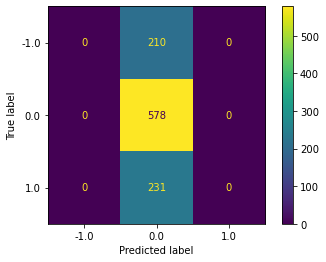

In [59]:
plot_confusion_matrix(grid_search_cv_dt, X_train, Y_train)

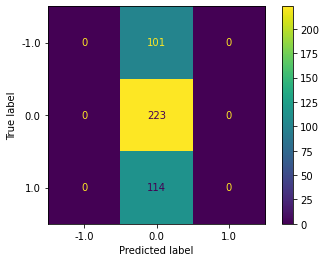

In [60]:
plot_confusion_matrix(grid_search_cv_dt, X_test, Y_test)

### Random Forrest 

In [61]:
# Random Forest

rf_fit = RandomForestClassifier(random_state = 42).fit(X_train, Y_train)

In [62]:
mean_squared_error(Y_train, rf_fit.predict(X_train))

0.0

In [63]:
mean_squared_error(Y_test, rf_fit.predict(X_test))

0.7397260273972602

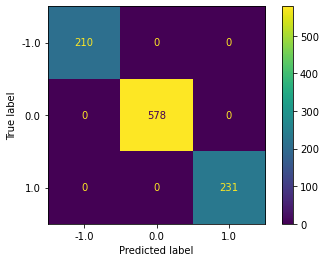

In [64]:
plot_confusion_matrix(rf_fit, X_train, Y_train) 

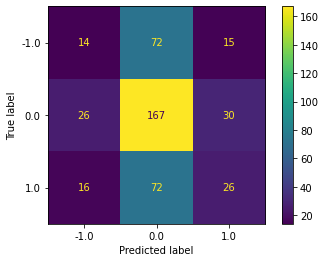

In [65]:
plot_confusion_matrix(rf_fit, X_test, Y_test)

### KNN

In [66]:
# KNN

knn_pipeline = make_pipeline(KNeighborsClassifier())

knn_fit = knn_pipeline.fit(X_train, Y_train)

In [67]:
mean_squared_error(Y_train, knn_fit.predict(X_train))

0.5191364082433758

In [68]:
mean_squared_error(Y_test, knn_fit.predict(X_test))

0.8310502283105022

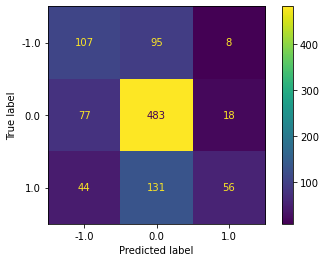

In [69]:
plot_confusion_matrix(knn_fit, X_train, Y_train) 

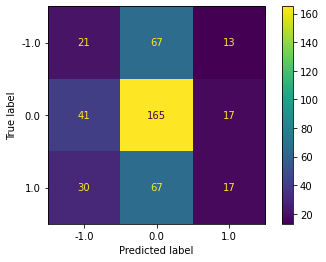

In [70]:
plot_confusion_matrix(knn_fit, X_test, Y_test)